# 7. Limit Cycles

## Preamble

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
from scipy.optimize import root
from scipy.misc import derivative
import scipy.linalg as lg

import sympy as sp
import fractions as fra

from tabulate import tabulate

from ipywidgets import interact

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%run -i "rcParameters.py"
#from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"]='Times New Roman'
plt.rcParams["mathtext.fontset"]='stix';

In [3]:
# set fontsize in markdown cells
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

## Utility functions

In [4]:
# Phase portrait: streamplot X,Y,Vx=dx/dt,Vy=dy/dt
def PP_2d(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)
    ax.streamplot(X,Y,U,V,density=dens,
                 linewidth=lw,color=col,arrowstyle='->')
    return ax

# Phase portrait: streamlines through selected points
def PP_2d_sp(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k',ar_s='->'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle=ar_s)
    return ax    

In [5]:
def get_FP_data(f1,f2,tab=True):
    '''
    input: f1(x,y) and f2(x,y) for 2D dynamical system
    output: FPs and attributes: tau, delta, tau^2-4.delta, 
                                eigen-values/-vectors of Jacobian matrix
    '''
    FPs = sp.solve((f1(x,y),f2(x,y)),x,y) 
    FPsd= [{x:a[0],y:a[1]} for a in FPs]
    print('Fixed points: ',FPsd)

    A = lambda x,y: sp.Matrix([f1(x,y),f2(x,y)]).jacobian([x,y])
    display(Latex(r'$A ={}$'.format(sp.latex(A(x,y)))))

    A_FPs = [A(x,y).subs(a) for a in FPsd]
    display(Latex(r'For each FPs evaluate $A$, $\tau=Tr(A)$, $\Delta=det(A)$, $\tau^2-4\Delta$, $\lambda_{{1,2}}$, and $v_{{1,2}}$'))
    [display(a) for a in A_FPs];

    tau   = [a.trace() for a in A_FPs]
    display(Latex(r'$\tau = {}$'.format(sp.latex(tau))))
    delta = [a.det()   for a in A_FPs]
    display(Latex(r'$\Delta = {}$'.format(sp.latex(delta))))
    disc  = [t**2 - 4*d for t,d in zip(tau,delta)]
    display(Latex(r'$\tau^2-4\Delta = {}$'.format(sp.latex(disc))))

    # calculate eigenvalues and eigenfunctions of the Jacobian matrices for each FP
    eig_sys = [a.eigenvects() for a in A_FPs]
    mu = [[a[0][0],a[1][0]] for a in eig_sys]
    display(Latex(r'$\lambda_{{1,2}} = {}$'.format(sp.latex(mu))))
    V  = [[list(a[0][2][0]),list(a[1][2][0])] for a in eig_sys]
    display(Latex(r'$V_{{1,2}} = {}$'.format(sp.latex(V))))

    # tabulate data for FPs
    if tab :
        table=[[FPsd[i],tau[i],delta[i],disc[i],mu[i],V[i]] for i in np.arange(len(FPs))]
        print(tabulate(table,headers=('Fixed point','tau','delta','disc','lambda','eigenvectors'),
                   tablefmt='fancy_grid'))
    return FPs, tau, delta, disc, mu, V

## 7.1.1 Simple Limit Cycle

Consider the 2D dynamical system described by $\dot{r}=r(1-r^2)$ and $\dot{\theta}=1$ in polar coordinates.

In [6]:
# calculate the radial fixed points (FPs) 
x,y,q,t = sp.symbols('x,y,q,t',real=True)
r,r0 = sp.symbols('r,r0',nonnegative=True)

f_r = lambda r: r*(1-r**2) 
f_q = lambda q: 1

FPs = sp.solve(f_r(r),r) 
print('Radial fixed points: r =',FPs)
pFPs = [f_r(r).diff().subs(r,a) for a in FPs]
print(pFPs)

Radial fixed points: r = [0, 1]
[1, -2]


$r=0$ is an unstable FP. 

$r=1$ is a __limit cycle__.

Next, find the trajectory {$r(t)\equiv\rho(t), \theta(t)=t$}, corresponding to initial condition $\rho(0)=r_0$

In [7]:
# integrate the radial ODE
rho = sp.Function('rho',real=True)
sol = sp.dsolve(rho(t).diff()-f_r(rho(t)),rho(t),ics={rho(0): r0})
sol

Eq(rho(t), sqrt(-1/(-exp(2*t) + 1 - 1/r0**2))*exp(t))

In [8]:
# convert rho(t) in a numpy function
rho_ = sp.lambdify((t,r0),sol.rhs,'numpy')

Plot the trajectory $r=\rho(\theta)$ for different $r_0=\rho(0)$

In [9]:
q_ = np.linspace(0,2*np.pi,100)
xc_= np.cos(q_)
yc_= np.sin(q_)
t_ = np.arange(0,5*np.pi,0.1)

@interact(r0=(0.001,2.1,0.2))
def update(r0=0.001):
    x_ = rho_(t_,r0)*np.cos(t_)
    y_ = rho_(t_,r0)*np.sin(t_)
    fig, ax=plt.subplots(figsize=(6,6))
    ax.plot(xc_,yc_,'r-',lw=6,alpha=0.6)
    ax.plot(x_,y_,'k-',lw=2)
    ax.set_aspect('equal')
    ax.set_xlim(-1.1,2.1)
    ax.set_ylim(-1.1,1.1)
    ax.grid()
    plt.show()

interactive(children=(FloatSlider(value=0.001, description='r0', max=2.1, min=0.001, step=0.2), Output()), _do…

The dynamical equations in Cartesian coordinates

$\dot{x}=(1-x^2-y^2)x-y\;$; $\;\dot{y}=(1-x^2-y^2)y+x$

Draw the _phase portrait_ 

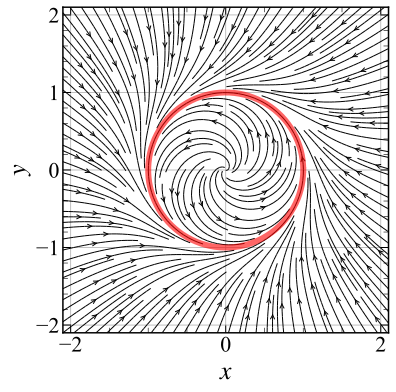

In [10]:
# phase portrait 
f1 = lambda x,y: (1-x**2-y**2)*x-y
f2 = lambda x,y: (1-x**2-y**2)*y+x

x1,x2=-2.1,2.1; y1,y2=-2.1,2.1
fig, ax=plt.subplots()
PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=2)
# draw the limit cycle
ax.plot(xc_,yc_,'r-',lw=6,alpha=0.6)

ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
# ax.set_xticks(np.arange(-4,5,2))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
# fig.savefig('FIGS/fig_711_pp.pdf')
plt.show()

## 7.1.2 van der Pol oscillator

vdP equations: $\dot{x}=y\;$, $\;\dot{y}=-x+\mu(1-x^2)y$

- for $|x|<1$ describe _self-sustained_ oscillations

#### Calculate and plot $y(x)$, $x(t)$ and $y(t)$

In [ ]:
# define RHS of vdP eqs
def vdPeq(xy,t,mu):
    x,y = xy
    return [y,-x+mu*(1-x*x)*y]
# solve vdP eqs
def txy_vdP(T,dt,xy0,mu):
    t = np.arange(0,T,dt)
    return [t,odeint(vdPeq,xy0,t,args=(mu,))]

In [ ]:
# plot vdP trajectory
t_max=30; dt=0.01;
@interact(mu=(0.5,2.,0.25),x0=(-4,4,0.2),y0=(-4,4,0.2))
def update(mu=1,x0=1,y0=0):
    [t,sol] = txy_vdP(t_max,dt,[x0,y0],mu)

    fig, ax=plt.subplots(3,1,figsize=(6,12),gridspec_kw=dict(height_ratios=[2,1,1],hspace=0.3))
    ax[0].plot(sol[:,0],sol[:,1],'k-',lw=2)
    ax[0].set_xlim(-4,4)
    ax[0].set_ylim(-4,4)
    ax[0].set_xlabel('$x$')
    ax[0].set_ylabel('$y$')
    
    ax[1].plot(t,sol[:,0],'b-',lw=2)
    ax[2].plot(t,sol[:,1],'r-',lw=2)
#     ax[1].set_xlabel('$t$')
    ax[2].set_xlabel('$t$')
    ax[1].set_ylabel('$x$')
    ax[2].set_ylabel('$y$')
    [a.grid() for a in ax]
    fig.align_ylabels(ax)
    plt.show()

#### Construct the phase portrait

In [ ]:
# phase portrait 
f1 = lambda x,y: y
mu = 1
f2 = lambda x,y: -x+mu*(1-x*x)*y

x1,x2=-4,4; y1,y2=-4,4
fig, ax=plt.subplots()
# PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=2)

d0=3; n2=15
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n2),pp1(n2)*0]),ax,col='k',dens=d0)
n2=8
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,-0.5,n2),pp1(n2)*2]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(0.5,x2,n2),-pp1(n2)*2]),ax,col='k',dens=d0)
n2=6
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-2,2,n2),pp1(n2)*3.9]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-2,2,n2),-pp1(n2)*3.9]),ax,col='k',dens=d0)

# draw the limit cycle

[t,sol] = txy_vdP(t_max,dt,[1,0],mu)
t1=1000
ax.plot(sol[t1:,0],sol[t1:,1],'r-',lw=4,alpha=0.6)

ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
# ax.set_xticks(np.arange(-4,5,2))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
# fig.savefig('FIGS/vdP_pp_v2.pdf')
plt.show()

## 7.3.1 _Poincare-Brendixson_ theorem

Consider the 2D dynamical system described by $\dot{r}=r(1-r^2)+\mu\, r\cos\theta\;$ and $ \; \dot{\theta}=1$ in polar coordinates.

Find the trajectory {$r(t)\equiv\rho(t), \theta(t)=t$}, corresponding to initial condition {$\rho(0)=r_0, \theta(0)=\theta_0$}

In [ ]:
# define RHS of the dynamical equations 
def eqs(rq,t,mu):
    r,q = rq
    return [r*(1-r*r)+mu*r*np.cos(q),1]
# integrate the dynamical equation
def txy(T,dt,rq0,mu):
    t = np.arange(0,T,dt)
    return [t,odeint(eqs,rq0,t,args=(mu,))]

Plot the trajectory {$x=r\cos\theta$, $y=r\sin\theta$} for different initial conditions {$r_0,\theta_0=0$} and parameter $\mu$.

In [ ]:
# plot trajectory
t_max=30; dt=0.01;

# {x0,y0}=unit circle
q_=np.linspace(0,2*np.pi,80)
x0=np.cos(q_);y0=np.sin(q_)

@interact(mu=(0.,2,0.1),r0=(0.1,2,0.2))
def update(mu=0.5,r0=1.):
    [t,sol] = txy(t_max,dt,[r0,0],mu)
    r=sol[:,0]; q=sol[:,1] 

# r1 < r(t) < r2
    r2=(1+mu)**0.5
    if mu <= 1:
        r1=(1-mu)**0.5
    else:
        r1=0
        
    fig, ax=plt.subplots()
# plot circles with r1=sqrt(1-mu) and r2=sqrt(1+mu)    
    ax.plot(r1*x0,r1*y0,'k--',lw=2,alpha=0.5)
    ax.plot(r2*x0,r2*y0,'k--',lw=2,alpha=0.5)
# plot {x(t),y(t)}
    ax.plot(r*np.cos(q),r*np.sin(q),'r-',lw=2)

    ax.set_aspect('equal')
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.grid()

    plt.show()

## 7.3.2  _Poincare-Brendixson_ theorem - ___glycolysis___ 

In [ ]:
fx = lambda x,y,a:   -x+a*y+x*x*y
fy = lambda x,y,a,b: b-a*y-x*x*y
xnc= lambda x,a: x/(a+x*x)
ync= lambda x,a,b: b/(a+x*x)
xA = lambda b: b
yA = lambda a,b: b/(a+b*b)
yB = lambda a,b: b/a

#### Stability (bifurcation) diagram

In [ ]:
# bifurcation diagram
a_ = np.linspace(0,0.15,80)
b_ = np.linspace(0,1.2,80)
A,B= np.meshgrid(a_,b_)
Z = B**4+(2*A-1)*B**2+A*(1+A)
fig, ax=plt.subplots()
ax.contour(A,B,Z,levels=[0],colors='k',linewidths=3)
ax.contourf(A,B,Z,levels=[-1e2,0],colors='gray',alpha=0.4)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')
ax.set_xticks(np.arange(0.05,0.16,0.05))
ax.text(0.2,0.45,'   stable\nlimit cycle',fontsize=24,transform=ax.transAxes)
ax.text(0.6,0.14,'   stable\nfixed point',fontsize=24,transform=ax.transAxes)
# fig.savefig('FIGS/glycolysis_BD.pdf')
ax.grid()
plt.show()

#### Phase portrait

In [ ]:
# determine the limit cycle
a0=0.08; b0=0.6
# a0=0.3; b0=0.6

f1 = lambda x,y: fx(x,y,a0)
f2 = lambda x,y: fy(x,y,a0,b0)

# find the limit cycle
t_max=1200;dt=0.01;t1=1100
t_ = np.arange(0,t_max,dt)
def eqs(xy,t):
    x,y=xy
    return [f1(x,y),f2(x,y)]
xy_LC = odeint(eqs,[0.5,0.5],t_)
x_LC = xy_LC[t1:,0]
y_LC = xy_LC[t1:,1]

In [ ]:
# phase portrait 

x1,x2=-0.1,3.5; y1,y2=-0.1,3
fig, ax=plt.subplots()
# PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=1)

d0=2; n2=24
ppx = lambda x1,x2,nx: np.linspace(0,x2,nx)
pp1 = lambda nx: np.ones(nx)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n2),pp1(n2)*2.5]),ax,col='k',dens=d0)
n2=14
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n2),pp1(n2)*0.]),ax,col='k',dens=d0)
n2=8
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(0.8,1.3,n2),pp1(n2)*1]),ax,col='k',dens=d0)

# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([[1.42,1.6],[1,0.5]]),ax,col='k',dens=1)

# draw the limit cycle
ax.plot(x_LC,y_LC,'r-',lw=4,alpha=0.6)

ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
# ax.set_xticks(np.arange(-4,5,2))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
ax.axhline(0,4,0,c='b',lw=2)
ax.axvline(0,4,0,c='b',lw=2)
ax.text(2.5,2.5,'$a=${}'.format(a0),fontsize=24,bbox=dict(edgecolor='white',facecolor='white', alpha=0.8))
ax.text(2.5,2.2,'$b=${}'.format(b0),fontsize=24,bbox=dict(edgecolor='white',facecolor='white', alpha=0.8))
# fig.savefig('FIGS/glycolysis_pp_v2.pdf')
plt.show()

## 7.5 Relaxation Oscillations

In [ ]:
# plot vdP trajectory
t_max=100; dt=0.001;
mu_ = 45
[t,sol] = txy_vdP(t_max,dt,[1,10],mu_)

fig, ax=plt.subplots(2,1,figsize=(6,8),gridspec_kw=dict(height_ratios=[2,1],hspace=0.3))
ax[0].plot(sol[:,0],sol[:,1],'k-',lw=2)
#     ax[0].set_xlim(-4,4)
#     ax[0].set_ylim(-4,4)
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')

ax[1].plot(t,sol[:,0],'b-',lw=2)
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$x$')
[a.grid() for a in ax]
fig.align_ylabels(ax)
plt.show()

In [ ]:
# periode T: approximation
T_= np.round(mu_*(3-2*np.log(2)),2)
print('T ~',T_)

In [ ]:
# periode T: exact
# [t,sol] = txy_vdP(80,dt,[1,0],mu_)
xt = interpolate(t,sol[:,0])
t0_= xt.roots()
T0 = t0_[-1]-t0_[-3]
print('T =',np.round(T0,2))

Rewrite vdP equation as: $\dot{x}=\mu[y-F(x)]\,;\; \dot{y}=-x/\mu$, where $F(x)=\int_0^x f(u)du = x^3/3-x$

In [ ]:
# define RHS of vdP eqs
F = lambda x: x**3/3-x
def vdPeq1(xy,t,mu):
    x,y = xy
    return [mu*(y-F(x)),-x/mu]
# solve vdP eqs
def txy_vdP1(T,dt,xy0,mu):
    t = np.arange(0,T,dt)
    return [t,odeint(vdPeq1,xy0,t,args=(mu,))]
# calculate trajectory
t_max=250; dt=0.01;
mu_ = 45
[t,sol] = txy_vdP1(t_max,dt,[1,2],mu_)
# plot PP {x,y}, and x(t)
fig, ax=plt.subplots(2,1,figsize=(6,8),gridspec_kw=dict(height_ratios=[2,1],hspace=0.3))
ax[0].plot(sol[:,0],sol[:,1],'k-',lw=2)
xx = np.linspace(-2.5,2.5,50)
ax[0].plot(xx,F(xx),'r-',lw=4,alpha=0.3)
ax[0].set_xlim(-3,3)
ax[0].set_ylim(-3,3)
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')

ax[1].plot(t,sol[:,0],'b-',lw=2)
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$x$')
ax[1].set_ylim(-3,3)
[a.grid() for a in ax]
fig.align_ylabels(ax)
plt.show()

In [ ]:
# periode T: exact
# [t,sol] = txy_vdP(80,dt,[1,0],mu_)
xt = interpolate(t,sol[:,0])
t0_= xt.roots()
T0 = t0_[-1]-t0_[-3]
print('T =',np.round(T0,2))